# Tutorial: JAX 101
https://jax.readthedocs.io/en/latest/jax-101/index.html

## JAX As Accelerated NumPy

### Getting started with JAX numpy

In [1]:
import jax
import jax.numpy as jnp

x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


In [2]:
x

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

JAX はCPU,GPU,TPUと異なるバックエンドでの実行を同じコードで実現できる

In [4]:
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

97.1 µs ± 221 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [5]:
import numpy as np

long_vector = np.arange(int(1e7))
%timeit np.dot(long_vector, long_vector)

5.91 ms ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### JAX first transformation: `grad`

In [8]:
def sum_of_squares(x):
    '''
    f = x^2
    f' = 2x
    '''
    return jnp.sum(x ** 2)

In [7]:
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))
print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


In [11]:
def sum_squared_error(x, y):
    return jnp.sum((x - y) ** 2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])
print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


`grad()` の `argnums` で引数の番号を指定することで，対応した偏微分を求めることができる

In [13]:
print(jax.grad(sum_squared_error, argnums=(0))(x,y))
print(jax.grad(sum_squared_error, argnums=(1))(x, y))
print(jax.grad(sum_squared_error, argnums=(0, 1))(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]
[0.20000005 0.19999981 0.19999981 0.19999981]
(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32), DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))


### Value and Grad
値と勾配を両方取得する方法

f(x) と jax.grad(f)(x) の値が返ってくる

In [14]:
jax.value_and_grad(sum_squared_error)(x, y)

(DeviceArray(0.03999995, dtype=float32),
 DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

### Auxiliary data
例えが loss func の中間出力も取得したい場合，通常の`jax.grad`ではエラーが出るので，引数`hax_aux=True`をつける

In [15]:
def squared_error_with_aux(x, y):
    return sum_squared_error(x, y), x-y

In [16]:
jax.grad(squared_error_with_aux)(x, y)

TypeError: Gradient only defined for scalar-output functions. Output was (DeviceArray(0.03999995, dtype=float32), DeviceArray([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32)).

In [17]:
jax.grad(squared_error_with_aux, has_aux=True)(x, y)

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32))

### Difference from NumPy
JAXによる変換を意図した関数では下記のような副作用は避けたほうが良い

In [18]:
x = np.array([1, 2, 3])

def in_place_modify(x):
    x[0] = 123
    return None

in_place_modify(x)
x

array([123,   2,   3])

In [19]:
in_place_modify(jnp.array(x))

TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [20]:
def jax_in_place_modify(x):
    return x.at[0].set(123)

y = jnp.array([1, 2, 3])
jax_in_place_modify(y)

DeviceArray([123,   2,   3], dtype=int32)

In [21]:
y

DeviceArray([1, 2, 3], dtype=int32)

### Your first JAX training loop

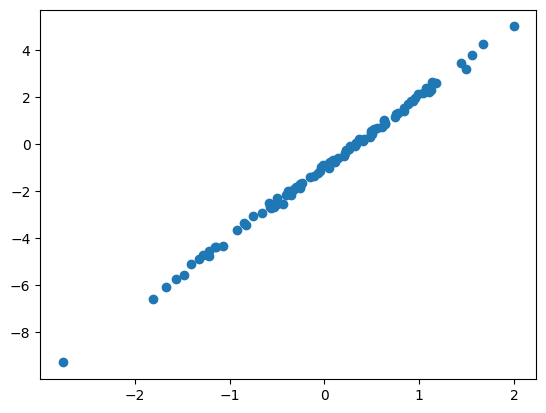

In [23]:
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100, ))
noise = np.random.normal(scale=0.1, size=(100, ))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [24]:
def model(theta, x):
    '''Computes wx + b on a batch of input x.'''
    w, b = theta
    return w * x + b

In [25]:
def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction - y) ** 2)

In [26]:
def update(theta, x, y, lr=0.1):
    return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 3.01, b: -0.99


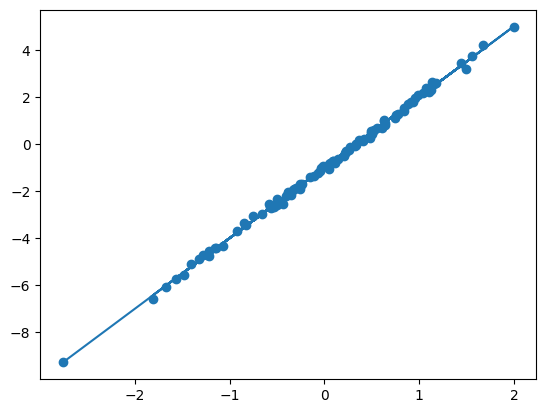

In [27]:
theta = jnp.array([1., 1.])

for _ in range(1000):
    theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f'w: {w:<.2f}, b: {b:<.2f}')

## Just In Time Compilation with JAX
JAX がどのように動き，パフォームさせることができるかを見ていく．具体的には，JAX PythonをJITコンパイルし，XLAによって効率的に実行可能とする`jax.jit()`について見ていく．

jaxでは，python func を jaxpr と呼ばれる中間言語にコンバートし，これに変換をかける

In [28]:
global_list = []
def log2(x):
    global_list.append(x)
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2

print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


In [29]:
def log2_with_print(x):
    print('printed x:', x)
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2)
    return ln_x / ln_2

print(jax.make_jaxpr(log2_with_print)(3.))

printed x: Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


jaxpr は与えられたパラメータに対して実行された過程を捉えるので，関数ないに分岐があったとしても処理された部分だけをトレースする

In [30]:
def log2_if_rank(x):
    if x.ndim == 2:
        ln_x = jnp.log(x)
        ln_2 = jnp.log(2)
        return ln_x / ln_2
    else:
        return x

print(jax.make_jaxpr(log2_if_rank)(jnp.array([1, 2, 3])))

{ lambda ; a:i32[3]. let  in (a,) }


### JIT compiling a function
下記のコードは実行されるたびにアクセラレータに送られている

In [31]:
def selu(x, alpha=1.67, lambda_=1.05):
    return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(1000000)
%timeit selu(x).block_until_ready()

414 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [32]:
selu_jit = jax.jit(selu)
selu_jit(x).block_until_ready()
%timeit selu_jit(x).block_until_ready()

36.7 µs ± 539 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Why can't we just JIT everything?
jit 時には jaxpr がトレースに使用する実際の値に依存するため，トレースされる値の型がコンパイル時に既知である必要がある．下記の場合，トレースされる値を条件分岐に使用しておりこれを満たさない

In [33]:
def f(x):
    if x > 0:
        return x
    else:
        return 2 * x

f_jit = jax.jit(f)
f_jit(10)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
The error occurred while tracing the function f at /tmp/ipykernel_8388/3893949707.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument 'x'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [35]:
def g(x, n):
    i = 0
    while i < n:
        i += 1
    return x + i

g_jit = jax.jit(g)
g_jit(10, 20)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
The error occurred while tracing the function g at /tmp/ipykernel_8388/3822546354.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument 'n'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

この問題に対処する方法としては，条件分岐を避けるか，`jax.lax.cond` のような制御フロー演算子を使用する．これらが不可能な場合は，関数の一部をjit化することを検討する．例えば，関数の中で最も計算量の多い部分がループの内側にある場合，その部分を切り出してjit化する．

In [36]:
@jax.jit
def loop_body(prev_i):
    return prev_i + 1

def g_inner_jitted(x, n):
    i = 0
    while i < n:
        i = loop_body(i)
    return x + i

g_inner_jitted(10, 20)

DeviceArray(30, dtype=int32, weak_type=True)

入力の値を条件とする関数をjit化する必要がある場合，`static_argnums` や `static_argnames` を指定し，特定の入力をトレースしないようにすることができる．代償として，得られる jaxpr は柔軟性に欠け，指定する静的入力の新しい値ごとにコンパイルを必要とする

In [37]:
f_jit_correct = jax.jit(f, static_argnums=0)
print(f_jit_correct(10))

10


In [38]:
g_jit_correct = jax.jit(g, static_argnames=['n'])
print(g_jit_correct(10, 20))

30


In [39]:
from functools import partial

@partial(jax.jit, static_argnames=['n'])
def g_jit_decorated(x, n):
    i = 0
    while i < n:
        i += 1
    return x + i

print(g_jit_decorated(10, 20))

30


### When to use JIT
jitコンパイルのオーバーヘッドがあるため，上記の例はあまりjit コンパイルする価値はない．通常はコンパイルした関数が複雑で，何度も実行する場合に効果がある．これは機械学習では一般的なことで，大規模で複雑なモデルをコンパイルし，それを反復して実行することが多い．理想的には，可能な限り大きな塊，理想的には更新ステップ全体をjitしたい．そうすることでコンパイラが最適化するための最大の自由度を得ることができる．

In [41]:
print('g gitted:')
%timeit g_jit_correct(10, 20).block_until_ready()

print('g:')
%timeit g(10, 20)

g gitted:
34.5 µs ± 495 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
g:
798 ns ± 0.54 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


### Caching
`jax.jit()`は関数のハッシュに依存しているが，ループの中で`functools.partial`, `lambda` を使用してjitしていると，毎回異なるハッシュ値が生成されるため避けるべきである

In [42]:
from functools import partial

def unjitted_loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted_partial(x, n):
  i = 0
  while i < n:
    # Don't do this! each time the partial returns
    # a function with different hash
    i = jax.jit(partial(unjitted_loop_body))(i)
  return x + i

def g_inner_jitted_lambda(x, n):
  i = 0
  while i < n:
    # Don't do this!, lambda will also return
    # a function with a different hash
    i = jax.jit(lambda x: unjitted_loop_body(x))(i)
  return x + i

def g_inner_jitted_normal(x, n):
  i = 0
  while i < n:
    # this is OK, since JAX can find the
    # cached, compiled function
    i = jax.jit(unjitted_loop_body)(i)
  return x + i

print("jit called in a loop with partials:")
%timeit g_inner_jitted_partial(10, 20).block_until_ready()

print("jit called in a loop with lambdas:")
%timeit g_inner_jitted_lambda(10, 20).block_until_ready()

print("jit called in a loop with caching:")
%timeit g_inner_jitted_normal(10, 20).block_until_ready()

jit called in a loop with partials:
164 ms ± 501 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
jit called in a loop with lambdas:
163 ms ± 600 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
jit called in a loop with caching:
10.3 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Automatic Vectorization in JAX

### Manual Vectorization

In [44]:
x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
    output = []
    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))
    return jnp.array(output)

convolve(x, w)

DeviceArray([11., 20., 29.], dtype=float32)

上記の関数を[x, x]，[w, w]の行列に適用したい場合，愚直な方法としてはバッチごとにループで処理することであるが，これは非効率である

In [45]:
xs = jnp.stack([x, x])
ws = jnp.stack([w, w])

In [46]:
def manually_batched_convolve(xs, ws):
    output = []
    for i in range(xs.shape[0]):
        output.append(convolve(xs[i], ws[i]))
    return jnp.stack(output)

manually_batched_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

そのため，下記のように手動でベクトル化すればよいが，こうした書き換えは面倒で，エラーが発生しやすくなる

In [47]:
def manually_vectorized_convolve(xs, ws):
    output = []
    for i in range(1, xs.shape[-1] -1):
        output.append(jnp.sum(xs[:, i-1:i+2] * ws, axis=1))
    return jnp.stack(output, axis=1)

manually_vectorized_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

### Automatic Vectorization
`jax.jit()`と同様に関数をトレースし，各入力の最初にバッチ軸を自動的に追加している．バッチ次元が最初出ない場合は，`in_axes`, `out_axes`引数を追加して明示的に入出力におけるバッチ次元の位置を指定できる

In [48]:
auto_batch_convolve = jax.vmap(convolve)
auto_batch_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

In [49]:
auto_batch_convolve_v2 = jax.vmap(convolve, in_axes=1, out_axes=1)
xst = jnp.transpose(xs)
wst = jnp.transpose(ws)

auto_batch_convolve_v2(xst, wst)

DeviceArray([[11., 11.],
             [20., 20.],
             [29., 29.]], dtype=float32)

`jax.vmap()`は引数の1つだけがバッチ処理される場合にも対応している．

In [50]:
auto_batch_convolve_v3 = jax.vmap(convolve, in_axes=[0, None])
auto_batch_convolve_v3(xs, w)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

### Combining transformations

In [51]:
jitted_batch_convolve = jax.jit(auto_batch_convolve)
jitted_batch_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

## Advanced Automatic Differentiation in JAX
勾配計算は現代の機械学習における重要パートである．このセクションでは，自動微分法における高度なトピックを考察する

In [52]:
f = lambda x: x**3 + 2*x**2 - 3*x + 1
dfdx = jax.grad(f)

In [53]:
d2fdx = jax.grad(dfdx)
d3fdx = jax.grad(d2fdx)
d4fdx = jax.grad(d3fdx)

In [54]:
print(dfdx(1.))
print(d2fdx(1.))
print(d3fdx(1.))
print(d4fdx(1.))

4.0
10.0
6.0
0.0


多変数の場合，JAXにはヤコビアンを計算するための`jax.jacfwd()`, `jax.jacrev()`を提供している．これらは同じ答えを返すが，状況によりどちらが効率的かは異なる．詳しくは [video about autodiff](https://www.youtube.com/watch?v=wG_nF1awSSY)参照．

In [55]:
def hessian(f):
    return jax.jacfwd(jax.grad(f))

In [56]:
def f(x):
    return jnp.dot(x, x)

hessian(f)(jnp.array([1., 2., 3.]))

DeviceArray([[2., 0., 0.],
             [0., 2., 0.],
             [0., 0., 2.]], dtype=float32)

ただ，多くの場合でヘッセ行列自体を計算することは非効率で，ヘッセ行列とベクトルの積のような，行列全体を実体化せずに使用するためのTIPsが [The Autodiff Cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html)にある．

### Higher order optimization

In [ ]:
def meta_loss_fn(params, data):
    grads = jax.grad(loss_fn)(params, data)
    return loss_fn(params - lr * grads, data)

meta_grads = jax.grad(meta_loss_fn)(params, data)

### Stopping gradients

In [57]:
value_fn = lambda theta, state: jnp.dot(theta, state)
theta = jnp.array([0.1, -0.1, 0.])

In [58]:
s_tm1 = jnp.array([1., 2., -1.])
r_t = jnp.array(1.)
s_t = jnp.array([2., 1., 0.])

In [59]:
def td_loss(theta, s_tm1, r_t, s_t):
    v_tm1 = value_fn(theta, s_tm1)
    target = r_t + value_fn(theta, s_t)
    return (target - v_tm1) ** 2

td_update = jax.grad(td_loss)
delta_theta = td_update(theta, s_tm1, r_t, s_t)

delta_theta

DeviceArray([ 2.4, -2.4,  2.4], dtype=float32)

In [60]:
def td_loss(theta, s_tm1, r_t, s_t):
    v_tm1 = value_fn(theta, s_tm1)
    target = r_t + value_fn(theta, s_t)
    return (jax.lax.stop_gradient(target) - v_tm1) ** 2

td_update = jax.grad(td_loss)
delta_theta = td_update(theta, s_tm1, r_t, s_t)
delta_theta

DeviceArray([-2.4, -4.8,  2.4], dtype=float32)

`jax.lax.stop_gradient` は，ある損失からの勾配がニューラルネットワークのパラメータの一部にだけ影響するようにしたい場合 (例えば，他のパラメータは別の損失を使って学習される場合)にも有効

### Straight-through estimator using `stop_gradient`
straight-through estimator とは，微分不可能な関数の勾配を定義するためのトリックである．微分不可能な関数fが勾配を求めたい大きな関数の一部として用いられている場合，fが恒等関数であるかのようにするだけでよく，これは`jax.lax.stop_gradient`を使用することで実現できる

In [62]:
def f(x):
    return jnp.round(x) # non-defferentialbe

def straight_through_f(x):
    zero = x - jax.lax.stop_gradient(x)
    return zero + jax.lax.stop_gradient(f(x))

print('f(x):', f(3.2))
print('straight_through_f(x):', straight_through_f(3.2))

print('grad(f)(x):', jax.grad(f)(3.2))
print('grad(straight_through_f)(x):', jax.grad(straight_through_f)(3.2))

f(x): 3.0
straight_through_f(x): 3.0
grad(f)(x): 0.0
grad(straight_through_f)(x): 1.0


### Per-example gradients
ほとんどのMLシステムでは，データのバッチから勾配と更新を計算するが，バッチないの特定のサンプルに関する勾配や更新へのアクセスを必要とする場合がある (勾配の大きさに基づいてデータに優先順位をつける，サンプルごとにクリッピングや正規化を適用する場合など)．PyTorch, TFなどの多くのフレームワークでは，ライブラリがバッチ全体の勾配を直接蓄積するため，サンプルごとの勾配計算は容易ではない．サンプルごとに個別の損失を計算し，結果の勾配を集計することは非常に非効率である．JAXではこれを簡単かつ効率的に定義することが可能である．

In [63]:
perex_grads = jax.jit(jax.vmap(jax.grad(td_loss), in_axes=(None, 0, 0, 0)))

batched_s_tm1 = jnp.stack([s_tm1, s_tm1])
batched_r_t = jnp.stack([r_t, r_t])
batched_s_t = jnp.stack([s_t, s_t])

perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t)

DeviceArray([[-2.4, -4.8,  2.4],
             [-2.4, -4.8,  2.4]], dtype=float32)